# open img

Image shape: (640, 640, 3)


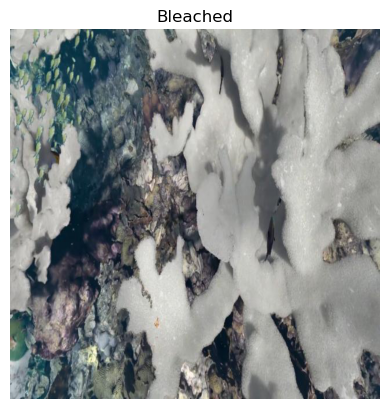

In [30]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

# View a random image from the training dataset
img = view_random_image(
  target_dir="Assets/Coral Reef Images/test/",
  target_class="Bleached"
)

In [31]:
img

array([[[102, 108, 106],
        [123, 129, 127],
        [138, 144, 142],
        ...,
        [ 34,  53,  67],
        [ 34,  53,  67],
        [ 37,  56,  70]],

       [[126, 132, 130],
        [143, 149, 147],
        [154, 160, 158],
        ...,
        [ 36,  54,  68],
        [ 34,  53,  67],
        [ 35,  54,  68]],

       [[150, 156, 154],
        [163, 169, 167],
        [168, 174, 172],
        ...,
        [ 37,  55,  69],
        [ 35,  54,  68],
        [ 32,  51,  65]],

       ...,

       [[159, 170, 176],
        [159, 170, 176],
        [155, 166, 172],
        ...,
        [ 46,  50,  62],
        [ 49,  53,  65],
        [ 44,  48,  60]],

       [[155, 166, 172],
        [156, 167, 173],
        [152, 163, 169],
        ...,
        [ 56,  60,  72],
        [ 57,  61,  73],
        [ 50,  54,  66]],

       [[151, 162, 168],
        [153, 164, 170],
        [150, 161, 167],
        ...,
        [ 73,  77,  89],
        [ 66,  70,  82],
        [ 54,  58,  70]]

In [32]:
img.shape

(640, 640, 3)

In [33]:
img/255

array([[[0.4       , 0.42352941, 0.41568627],
        [0.48235294, 0.50588235, 0.49803922],
        [0.54117647, 0.56470588, 0.55686275],
        ...,
        [0.13333333, 0.20784314, 0.2627451 ],
        [0.13333333, 0.20784314, 0.2627451 ],
        [0.14509804, 0.21960784, 0.2745098 ]],

       [[0.49411765, 0.51764706, 0.50980392],
        [0.56078431, 0.58431373, 0.57647059],
        [0.60392157, 0.62745098, 0.61960784],
        ...,
        [0.14117647, 0.21176471, 0.26666667],
        [0.13333333, 0.20784314, 0.2627451 ],
        [0.1372549 , 0.21176471, 0.26666667]],

       [[0.58823529, 0.61176471, 0.60392157],
        [0.63921569, 0.6627451 , 0.65490196],
        [0.65882353, 0.68235294, 0.6745098 ],
        ...,
        [0.14509804, 0.21568627, 0.27058824],
        [0.1372549 , 0.21176471, 0.26666667],
        [0.1254902 , 0.2       , 0.25490196]],

       ...,

       [[0.62352941, 0.66666667, 0.69019608],
        [0.62352941, 0.66666667, 0.69019608],
        [0.60784314, 0

In [35]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("Assets/Coral Reef Images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'Assets/Coral Reef Images'.
There are 2 directories and 0 images in 'Assets/Coral Reef Images\test'.
There are 0 directories and 135 images in 'Assets/Coral Reef Images\test\Bleached'.
There are 0 directories and 122 images in 'Assets/Coral Reef Images\test\Healthy'.
There are 2 directories and 0 images in 'Assets/Coral Reef Images\train'.
There are 0 directories and 4980 images in 'Assets/Coral Reef Images\train\Bleached'.
There are 0 directories and 4682 images in 'Assets/Coral Reef Images\train\Healthy'.
There are 2 directories and 0 images in 'Assets/Coral Reef Images\valid'.
There are 0 directories and 240 images in 'Assets/Coral Reef Images\valid\Bleached'.
There are 0 directories and 223 images in 'Assets/Coral Reef Images\valid\Healthy'.


In [54]:
import os


def trim_dataset(folder_path, keep_count=1500, dry_run=False):
    """
    Keeps the first 'keep_count' images in a folder and deletes the rest.
    
    Args:
        folder_path (str): Path to the folder containing images.
        keep_count (int): Number of images to keep (default 1500).
        dry_run (bool): If True, only prints what will be deleted. 
                        If False, actually deletes the files.
    """
    
    # 1. Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return

    # 2. Get list of image files only
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    all_files = os.listdir(folder_path)
    
    # Filter for images and sort them to ensure deterministic selection
    image_files = sorted([f for f in all_files if f.lower().endswith(valid_extensions)])
    
    total_images = len(image_files)
    print(f"Total images found: {total_images}")
    
    if total_images <= keep_count:
        print(f"Folder has fewer than {keep_count} images. No action needed.")
        return

    # 3. Identify files to delete
    # This selects everything starting from index 1500 to the end
    files_to_delete = image_files[keep_count:]
    
    print(f"Preparing to delete {len(files_to_delete)} images...")

    # 4. Delete the files
    for img_name in files_to_delete:
        file_path = os.path.join(folder_path, img_name)
        
        if dry_run:
            # Just print, don't delete
            print(f"[DRY RUN] Would delete: {img_name}")
        else:
            # Actually delete
            try:
                os.remove(file_path)
            except Exception as e:
                print(f"Error deleting {img_name}: {e}")

    if dry_run:
        print("\n--- DRY RUN COMPLETE ---")
        print(f"To actually delete these files, run the function again with dry_run=False")
    else:
        print(f"\nSuccess! Deleted {len(files_to_delete)} images. {keep_count} remain.")

# ==========================================
# USAGE
# ==========================================

# Define your path (using the raw string 'r' method we fixed earlier)
my_folder = r'Assets\Coral Reef Images\train\Healthy'

# Step 1: Run in SAFE MODE (Dry Run) first to check
trim_dataset(my_folder, keep_count=1500, dry_run=False)

# Step 2: Uncomment the line below ONLY when you are ready to delete
# trim_dataset(my_folder, keep_count=1500, dry_run=False)

Total images found: 4682
Preparing to delete 3182 images...

Success! Deleted 3182 images. 1500 remain.


In [55]:
for dirpath, dirnames, filenames in os.walk("Assets/Coral Reef Images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'Assets/Coral Reef Images'.
There are 2 directories and 0 images in 'Assets/Coral Reef Images\test'.
There are 0 directories and 135 images in 'Assets/Coral Reef Images\test\Bleached'.
There are 0 directories and 122 images in 'Assets/Coral Reef Images\test\Healthy'.
There are 2 directories and 0 images in 'Assets/Coral Reef Images\train'.
There are 0 directories and 1500 images in 'Assets/Coral Reef Images\train\Bleached'.
There are 0 directories and 1500 images in 'Assets/Coral Reef Images\train\Healthy'.
There are 2 directories and 0 images in 'Assets/Coral Reef Images\valid'.
There are 0 directories and 240 images in 'Assets/Coral Reef Images\valid\Bleached'.
There are 0 directories and 223 images in 'Assets/Coral Reef Images\valid\Healthy'.


# the model

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "Assets/Coral Reef Images/train/"
test_dir = "Assets/Coral Reef Images/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 9662 images belonging to 2 classes.
Found 257 images belonging to 2 classes.


c:\Users\Acer-Swift\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Acer-Swift\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 29/302 ━━━━━━━━━━━━━━━━━━━━ 5:57 1s/step - accuracy: 0.5577 - loss: 0.6562

KeyboardInterrupt: 